In [1]:
import os
import shutil
import random 

# --- Configuration for Image Organization ---
BASE_DIR = 'dataset/'
SOURCE_IMAGES_DIR = os.path.join(BASE_DIR, 'cropped_images_new')

# Destination directories
IMAGES_BASE_DEST_DIR = os.path.join(BASE_DIR, 'images') # Base for train/val/test: dataset/images/
TRAIN_DIR = os.path.join(IMAGES_BASE_DEST_DIR, 'train')   # dataset/images/train
VAL_DIR = os.path.join(IMAGES_BASE_DEST_DIR, 'val')       # dataset/images/val
TEST_DIR = os.path.join(IMAGES_BASE_DEST_DIR, 'test')     # dataset/images/test

# Split ratios
VAL_SPLIT = 0.1  # 10% for validation
TEST_SPLIT = 0.1 # 10% for testing
# TRAIN_SPLIT is implicitly 1 - VAL_SPLIT - TEST_SPLIT (e.g., 80%)

mapping_save_path = 'class_mapping.json'

def copy_images(imagePaths, destination_folder):
    """
    Copies a list of images to a destination folder, maintaining class subdirectories.
    Example source path: 'dataset/merged/class_name/image_name.png'
    Example destination: 'dataset/images/train/class_name/image_name.png'
    """
    if not imagePaths:
        print(f"No images to copy for {destination_folder}.")
        return

    # Check if the base destination folder exists and if not create it
    # The class-specific subfolders will be created as needed.
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        print(f"Created directory: {destination_folder}")

    for path in imagePaths:
        try:
            imageName = os.path.basename(path)  # e.g., image.png
            # The label is the name of the parent directory of the image file
            # e.g., if path = 'dataset/merged/classA/image1.png', dirname(path) = 'dataset/merged/classA'
            # basename(dirname(path)) = 'classA'
            label = os.path.basename(os.path.dirname(path))

            labelFolder = os.path.join(destination_folder, label)

            if not os.path.exists(labelFolder):
                os.makedirs(labelFolder)
            destination_path = os.path.join(labelFolder, imageName)
            shutil.copy(path, destination_path)
        except Exception as e:
            print(f"Error copying file {path} to {destination_folder}: {e}")
    print(f"Finished copying {len(imagePaths)} images to {destination_folder} and its subdirectories.")


def organize_dataset():
    """
    Loads images from the source directory, shuffles them, splits them into
    train, validation, and test sets, and copies them to respective directories.
    """
    print("[INFO] Starting dataset organization...")
    print(f"[INFO] Source directory: {SOURCE_IMAGES_DIR}")

    if not os.path.exists(SOURCE_IMAGES_DIR):
        print(f"[ERROR] Source directory '{SOURCE_IMAGES_DIR}' does not exist. Aborting.")
        return

    imagePaths = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp') # Common image extensions
    print(f"[INFO] Searching for images with extensions: {valid_extensions} in {SOURCE_IMAGES_DIR}")

    for root, dirs, files in os.walk(SOURCE_IMAGES_DIR):
        for file in files:
            if file.lower().endswith(valid_extensions):
                imagePaths.append(os.path.join(root, file))

    if not imagePaths:
        print(f"[INFO] No images found in '{SOURCE_IMAGES_DIR}'. Aborting.")
        return

    print(f"[INFO] Found {len(imagePaths)} images to process.")

    # Randomly shuffle the image paths
    random.shuffle(imagePaths)

    # Calculate split sizes
    num_images = len(imagePaths)
    num_val = int(num_images * VAL_SPLIT)
    num_test = int(num_images * TEST_SPLIT)
    num_train = num_images - num_val - num_test

    if num_train <= 0 or num_val < 0 or num_test < 0: # num_val or num_test could be 0, which is fine.
        print(f"[ERROR] Invalid split sizes: Train={num_train}, Val={num_val}, Test={num_test}. Check split ratios and dataset size.")
        return

    print(f"[INFO] Splitting dataset: {num_train} train, {num_val} validation, {num_test} test images.")

    # Create the paths based on the split
    trainPaths = imagePaths[:num_train]
    valPaths = imagePaths[num_train : num_train + num_val]
    testPaths = imagePaths[num_train + num_val :]

    # Ensure all images are assigned
    assert len(trainPaths) + len(valPaths) + len(testPaths) == num_images, "Mismatch in image split counts!"

    # Copy images to their respective directories
    print(f"\n[INFO] Copying training images to '{TRAIN_DIR}'...")
    copy_images(trainPaths, TRAIN_DIR)

    print(f"\n[INFO] Copying validation images to '{VAL_DIR}'...")
    copy_images(valPaths, VAL_DIR)

    print(f"\n[INFO] Copying testing images to '{TEST_DIR}'...")
    copy_images(testPaths, TEST_DIR)

    print("\n[INFO] Image organization complete.")
    print(f"Train data: {TRAIN_DIR}")
    print(f"Validation data: {VAL_DIR}")
    print(f"Test data: {TEST_DIR}")

organize_dataset()

[INFO] Starting dataset organization...
[INFO] Source directory: dataset/cropped_images_new
[INFO] Searching for images with extensions: ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp') in dataset/cropped_images_new
[INFO] Found 2020 images to process.
[INFO] Splitting dataset: 1616 train, 202 validation, 202 test images.

[INFO] Copying training images to 'dataset/images\train'...
Finished copying 1616 images to dataset/images\train and its subdirectories.

[INFO] Copying validation images to 'dataset/images\val'...
Finished copying 202 images to dataset/images\val and its subdirectories.

[INFO] Copying testing images to 'dataset/images\test'...
Finished copying 202 images to dataset/images\test and its subdirectories.

[INFO] Image organization complete.
Train data: dataset/images\train
Validation data: dataset/images\val
Test data: dataset/images\test


In [19]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.amp import autocast, GradScaler # Use 'cuda' specific autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import time # To measure training time

# --- Configuration ---
DATA_DIR = 'dataset/images'  # expects subfolders train/, val/, test/
BATCH_SIZE = 32 # Increased batch size for potentially faster training, adjust based on GPU memory
NUM_EPOCHS = 5
MODEL_SAVE_PATH = 'efficientnet_v2s_finetuned.pth' # Path to save the final model
mapping_save_path = 'class_mapping.json'

# --- Device Setup ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    # Enable cuDNN benchmark for potentially faster convolutions on fixed input sizes
    torch.backends.cudnn.benchmark = True
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

# --- Determine Number of Classes ---
try:
    train_dir = os.path.join(DATA_DIR, 'train')
    if not os.path.isdir(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    classes = os.listdir(train_dir)
    # Filter out potential hidden files/dirs like .DS_Store
    classes = [d for d in classes if os.path.isdir(os.path.join(train_dir, d))]
    NUM_CLASSES = len(classes)
    if NUM_CLASSES == 0:
        raise ValueError(f"No subdirectories found in {train_dir}. Expected class folders.")
    print(f"Found {NUM_CLASSES} classes: {classes}")
except Exception as e:
    print(f"Error determining number of classes: {e}")
    print("Please ensure DATA_DIR points to a directory containing 'train', 'val', and 'test' subfolders,")
    print("and that 'train' contains one subfolder per class.")
    exit() # Exit if class setup fails
# --- Preprocessing ---
# Use the recommended weights and transforms for EfficientNet-B0
# --- Preprocessing ---
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
img_size = 384 # Standard EfficientNet-B0 input size from weights.transforms()

# Define separate transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)), # Crop differently each time
    transforms.RandomHorizontalFlip(p=0.5),                  # Flip images horizontally sometimes
    transforms.RandomRotation(degrees=15),                    # Rotate slightly
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust colors
    transforms.ToTensor(),
    # Use normalization parameters from the pre-trained weights
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0) # Optional: Cutout/Random Erasing
])

# Keep validation/test transform simpler (usually matching evaluation protocol)
val_test_transform = weights.transforms() # Use the standard transforms for val/test
# --- Datasets and Loaders ---
print("Loading datasets...")
try:
    train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
    test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

    # Check if datasets are empty
    if not train_dataset or not val_dataset or not test_dataset:
         raise ValueError("One or more datasets (train, val, test) are empty or could not be loaded.")

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

    # Pin memory for faster CPU to GPU transfers if using CUDA
    pin_memory = True if DEVICE == torch.device("cuda") else False

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    print("DataLoaders created.")

    # Determine number of classes and save mapping
    num_classes = len(train_dataset.classes)
    class_mapping = train_dataset.class_to_idx
    print(f"Found {num_classes} classes: {train_dataset.classes}")

    # Save class mapping
    try:
        with open(mapping_save_path, 'w') as f:
            json.dump(class_mapping, f, indent=4)
        print(f"Class mapping saved to: {mapping_save_path}")
    except IOError as e:
        print(f"Warning: Could not save class mapping to {mapping_save_path}: {e}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure 'train', 'val', and 'test' subdirectories exist in DATA_DIR and contain images.")
    exit()

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Found 84 classes: ['Almonds', 'Apple', 'Artichoke', 'Avocado', 'Balaleet', 'Bamya', 'Banana', 'Basbousa', 'Bell pepper', 'bread', 'Broccoli', 'Burger', 'Burrito', 'Carrot', 'Cashews', 'Chicken_breast', 'Coconut', 'Corn', 'Crab', 'Cucumber', 'Dark_chocolate', 'Dates_with_tahini', 'Edamame', 'Eggs', 'Fattoush', 'Fries', 'Gers_Ogaily', 'Grape', 'Ground_beef', 'Harees', 'Hummus', 'Jireesh', 'Kebab', 'khabeesa', 'Kubba', 'laban_drink', 'Labneh', 'Lentil_soup', 'Lobster', 'Luqaimat', 'Majboos_Dajaj', 'Mallooba(Maqluba)', 'Modas_rice', 'Molokhia', 'Muhammara', 'Murabyan', 'Musakhan_Chicken', 'Noodles', 'om_ali', 'Orange (fruit)', 'Oyster', 'Pasta', 'Peach', 'Pear', 'Pineapple', 'Pizza', 'Plain_white_rice', 'Pomegranate', 'Potato', 'Pumpkin', 'Radish', 'Red_tea_with_mint_or_saffron', 'rice_with_meat', 'Saffron', 'Salmon', 'Samosa', 'Sandwich', 'Shrimp', 'Strawberry', 'Sunflower_seeds', 'Sweet_potatoes', 'Tabouleh', 'Taco', 'Tahini', 'Tamarind_juice

In [20]:
# --- Model Definition ---
print("Loading EfficientNet-B0 model...")
model = efficientnet_v2_s(weights=weights)

# Replace the final fully connected layer (classifier)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.39, inplace=True), # Keep dropout
    nn.Linear(num_ftrs, NUM_CLASSES),
)
model.to(DEVICE)
print(f"Model classifier modified for {NUM_CLASSES} classes.")
from torch.optim.lr_scheduler import ReduceLROnPlateau
# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Use AdamW which often works better with transformers and modern architectures
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=6e-2)
# Optional: Learning Rate Scheduler (e.g., reduce on plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
# Factor: Multiplies LR by this (0.1 = reduce to 10%)
# Patience: Number of epochs with no improvement after which LR is reduced.

# --- Mixed Precision Setup ---
# Only use GradScaler if on CUDA
scaler = GradScaler("cuda")
print(f"Mixed precision enabled: {scaler.is_enabled()}")

Loading EfficientNet-B0 model...
Model classifier modified for 84 classes.
Mixed precision enabled: True


c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Starting Training ---


[Epoch 1] Train Loss: 2.2262, Accuracy: 0.5674


[Epoch 1] Validation Accuracy: 0.8234


[Epoch 2] Train Loss: 0.6035, Accuracy: 0.8642


[Epoch 2] Validation Accuracy: 0.9052


[Epoch 3] Train Loss: 0.3028, Accuracy: 0.9261


[Epoch 3] Validation Accuracy: 0.9201
Validation accuracy improved from 0.0000 to 0.9201 with acc diff 0.0060. Saving best model...


[Epoch 4] Train Loss: 0.1932, Accuracy: 0.9511


[Epoch 4] Validation Accuracy: 0.9219


[Epoch 5] Train Loss: 0.1333, Accuracy: 0.9667


[Epoch 5] Validation Accuracy: 0.9359

--- Training Finished ---
Total Training Time: 19.72 minutes

--- Plotting Metrics ---
Metrics plot saved as training_validation_metrics.png


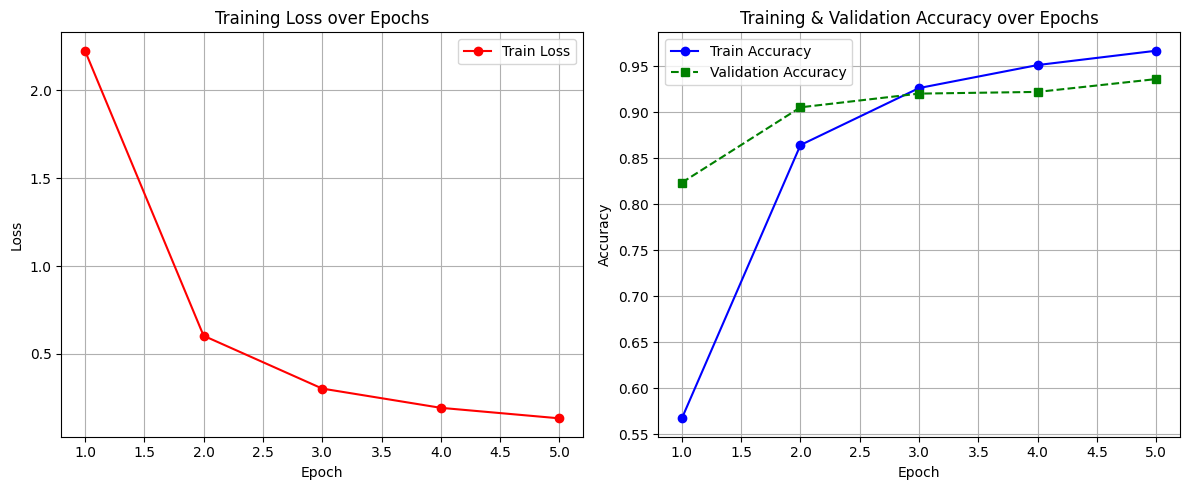


--- Evaluating on Test Set ---
Loading best model weights for final testing...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11920\2552031934.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_lo

[Epoch Final] Testing (Best Model) Accuracy: 0.9312

Final Test Accuracy (Best Model): 0.9312


In [21]:
# Lists to store metrics for plotting
train_losses, val_accuracies, train_accuracies = [], [], []

# --- Training Function ---
def train_one_epoch(epoch_num):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num}/{NUM_EPOCHS} [Training]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        # Use autocast only if on CUDA
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called.
        # Otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        running_loss += loss.item() * inputs.size(0) # Accumulate loss correctly
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar postfix
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(loss=loss.item(), acc=f"{batch_acc:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f"[Epoch {epoch_num}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# --- Validation Function ---
@torch.no_grad() # No need to track gradients during evaluation
def evaluate(data_loader, epoch_num=None, phase="Validation"):
    model.eval() # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    desc = f"Epoch {epoch_num if epoch_num else '?'} [{phase}]"
    progress_bar = tqdm(data_loader, desc=desc, leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # Use autocast for potential speedup even during inference on CUDA
        with autocast("cuda"):
            outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(acc=f"{batch_acc:.4f}")


    accuracy = correct_predictions / total_samples
    print(f"[Epoch {epoch_num if epoch_num else 'Final'}] {phase} Accuracy: {accuracy:.4f}")
    return accuracy

# --- Plotting Function ---
def plot_metrics():
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', linestyle='-', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', color='b')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.savefig("training_validation_metrics.png") # Save the plot
    print("Metrics plot saved as training_validation_metrics.png")
    plt.show() # Display the plot

# --- Main Execution ---
print("\n--- Starting Training ---")
start_time = time.time()

best_val_acc = 0.0 # Keep track of best validation accuracy for potential early stopping or saving best model

for epoch in range(1, NUM_EPOCHS + 1):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on validation set
    val_acc = evaluate(val_loader, epoch_num=epoch, phase="Validation")
    val_accuracies.append(val_acc)

    # Optional: Implement learning rate scheduling based on validation loss/accuracy
    if scheduler: 
        scheduler.step(val_acc)  # Or val_acc if using ReduceLROnPlateau with mode='max'

    # Save model if validation accuracy improves and is not overfitting
    acc_diff = abs(train_acc - val_acc)
    if val_acc > best_val_acc and acc_diff < 0.02:
        print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f} "
              f"with acc diff {acc_diff:.4f}. Saving best model...")
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {(end_time - start_time) / 60:.2f} minutes")

# --- Plot Training and Validation Metrics ---
print("\n--- Plotting Metrics ---")
plot_metrics()

# --- Testing the Model ---
print("\n--- Evaluating on Test Set ---")
# Option 1: Evaluate the final model after all epochs
# test_accuracy = evaluate(test_loader, phase="Testing")

# Option 2: Load the best model (based on validation accuracy) and test that
print("Loading best model weights for final testing...")
try:
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
    test_accuracy = evaluate(test_loader, phase="Testing (Best Model)")
    print(f"\nFinal Test Accuracy (Best Model): {test_accuracy:.4f}")
except FileNotFoundError:
    print("Warning: 'best_model.pth' not found. Testing the model from the final epoch.")
    test_accuracy = evaluate(test_loader, phase="Testing (Final Epoch Model)")
    print(f"\nFinal Test Accuracy (Final Epoch Model): {test_accuracy:.4f}")

In [22]:
### Inference on a single image
import os
import json
import torch
import torch.nn as nn
from torchvision.models import EfficientNet_V2_S_Weights, efficientnet_v2_s
from PIL import Image

# --- Configuration ---
MODEL_PATH = 'models/best_model.pth'
# IMAGE_PATH = r'dataset\images\test\Hummus\18.jpg'  # <<<--- Change this to your image file
IMAGE_PATH = r"dataset\images\test\Hummus\65570.jpg"
MAPPING_JSON_PATH = 'class_mapping.json'
NUM_CLASSES = 84

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Load Class Mapping ---
print(f"Loading class mapping from: {MAPPING_JSON_PATH}")
try:
    with open(MAPPING_JSON_PATH, 'r') as f:
        class_to_idx = json.load(f)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    if len(idx_to_class) != NUM_CLASSES:
        print(f"Warning: Found {len(idx_to_class)} classes, expected {NUM_CLASSES}")
except Exception as e:
    raise RuntimeError(f"Failed to load class mapping: {e}")

# --- Load Model ---
print("Loading model...")
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = efficientnet_v2_s(weights=weights)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.37, inplace=True), # Keep dropout
    nn.Linear(num_ftrs, NUM_CLASSES),
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# --- Preprocessing ---
preprocess = weights.transforms()

# --- Prediction Function ---
def predict_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(input_tensor)
            conf, idx = torch.max(torch.softmax(output, dim=1), 1)
        return idx_to_class.get(idx.item(), "Unknown"), conf.item()
    except Exception as e:
        print(f"Prediction error: {e}")
        return None, None

# --- Inference ---
if not os.path.exists(IMAGE_PATH):
    print(f"Image path does not exist: {IMAGE_PATH}")
else:
    print(f"Predicting image: {IMAGE_PATH}")
    label, confidence = predict_image(IMAGE_PATH)
    if label:
        print(f"-> Predicted Class: {label}")
        print(f"-> Confidence: {confidence:.4f}")

Using device: cuda
Loading class mapping from: class_mapping.json
Loading model...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11920\3907674394.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Predicting image: dataset\images\test\Hummus\65570.jpg
-> Predicted Class: Cucumber
-> Confidence: 0.5083


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# --- Classification Report and Confusion Matrix ---
print("\n--- Classification Report and Confusion Matrix ---")

# Put model in evaluation mode
model.eval()

# Lists to collect true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Generating predictions"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with autocast("cuda"):
            outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Load class names
class_names = [class_name for class_name, _ in sorted(train_dataset.class_to_idx.items(), key=lambda x: x[1])]

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


--- Classification Report and Confusion Matrix ---


Generating predictions: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]

                              precision    recall  f1-score   support

                     Almonds     1.0000    1.0000    1.0000         6
                       Apple     0.9333    1.0000    0.9655        14
                   Artichoke     1.0000    1.0000    1.0000        12
                     Avocado     1.0000    0.8571    0.9231         7
                    Balaleet     0.9091    1.0000    0.9524        10
                       Bamya     0.7895    0.8824    0.8333        17
                      Banana     1.0000    1.0000    1.0000        13
                    Basbousa     0.9091    0.9091    0.9091        11
                 Bell pepper     1.0000    1.0000    1.0000        21
                    Broccoli     1.0000    1.0000    1.0000         8
                      Burger     1.0000    0.9538    0.9764        65
                     Burrito     0.8750    1.0000    0.9333         7
                      Carrot     0.9231    0.9231    0.9231        13
                   


c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

Generating predictions: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]


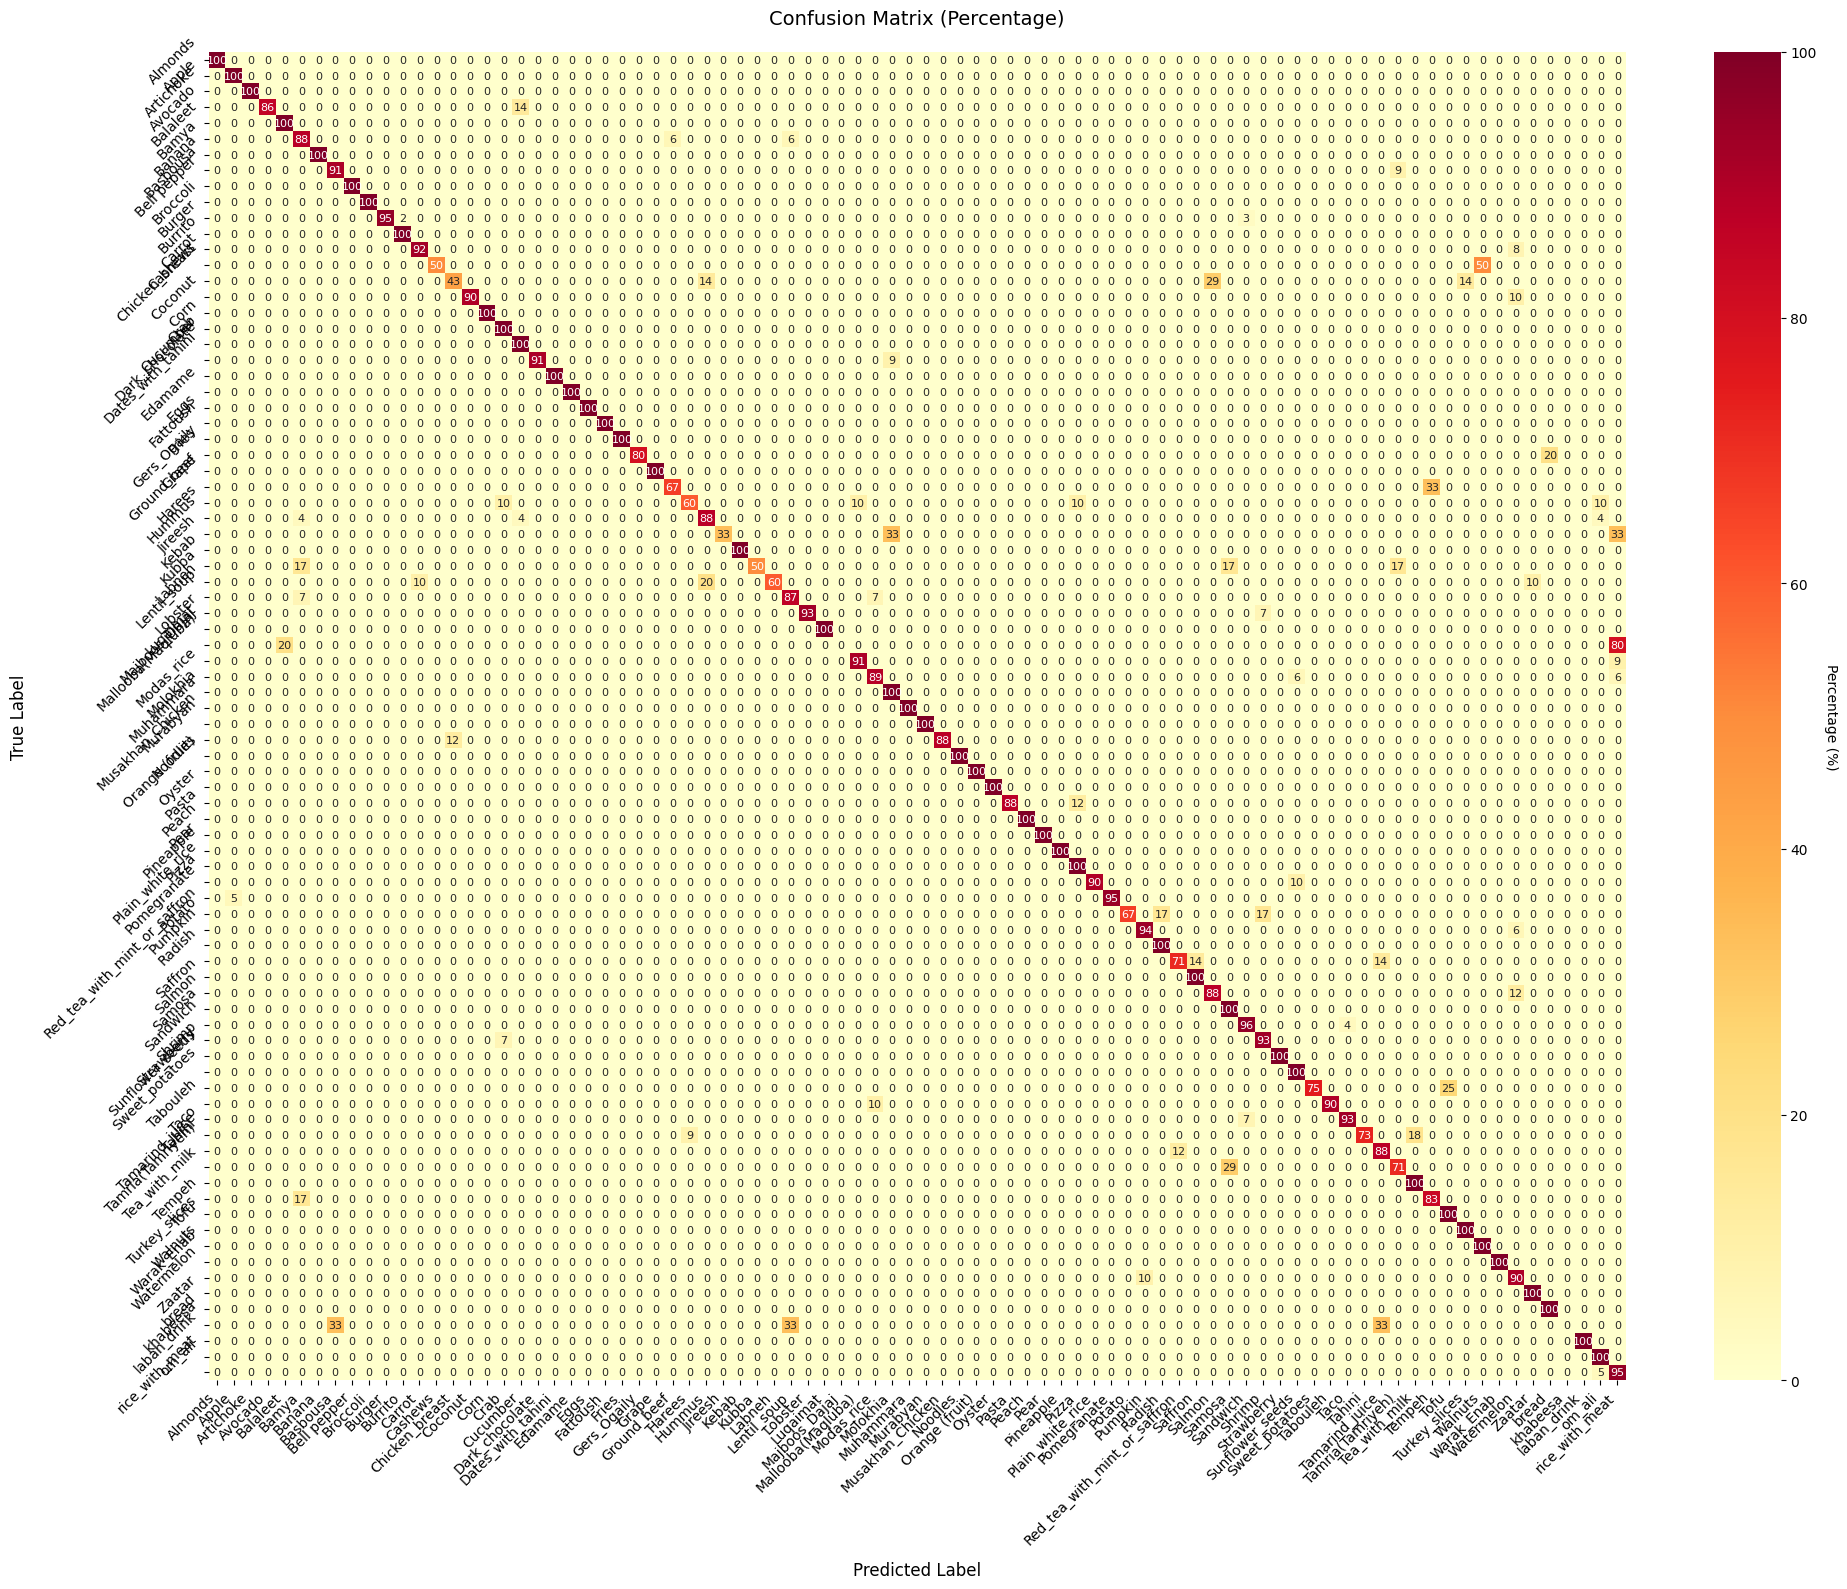


Misclassification Analysis:
--------------------------------------------------------------------------------

True Class: Avocado
  → Predicted as Cucumber: 1 times

True Class: Bamya
  → Predicted as Lentil_soup: 1 times
  → Predicted as Ground_beef: 1 times

True Class: Basbousa
  → Predicted as Tamria(Tamriyeh): 1 times

True Class: Burger
  → Predicted as Sandwich: 2 times
  → Predicted as Burrito: 1 times

True Class: Carrot
  → Predicted as Watermelon: 1 times

True Class: Cashews
  → Predicted as Walnuts: 2 times

True Class: Chicken_breast
  → Predicted as Salmon: 2 times
  → Predicted as Hummus: 1 times
  → Predicted as Turkey_slices: 1 times

True Class: Coconut
  → Predicted as Watermelon: 1 times

True Class: Dark_chocolate
  → Predicted as Molokhia: 1 times

True Class: Gers_Ogaily
  → Predicted as bread: 1 times

True Class: Ground_beef
  → Predicted as Tempeh: 1 times

True Class: Harees
  → Predicted as Crab: 1 times
  → Predicted as Pizza: 1 times
  → Predicted as Mal

In [24]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names, figure_size=(20, 16)):
    """
    Create a better visualization of the confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names
        figure_size: Size of the figure (width, height)
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Convert to percentage for better visualization
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    plt.figure(figsize=figure_size)
    
    # Create heatmap
    sns.heatmap(cm_percent, 
                annot=True,
                fmt='.1f' if cm_percent.max() < 100 else '.0f',
                cmap='YlOrRd',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={'size': 8})
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    
    # Add labels and title
    plt.xlabel('Predicted Label', fontsize=12, labelpad=10)
    plt.ylabel('True Label', fontsize=12, labelpad=10)
    plt.title('Confusion Matrix (Percentage)', fontsize=14, pad=20)
    
    # Add colorbar label
    cbar = plt.gca().collections[0].colorbar
    cbar.set_label('Percentage (%)', rotation=270, labelpad=15)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save high-resolution figure
    plt.savefig('confusion_matrix_enhanced.png', 
                dpi=300, 
                bbox_inches='tight')
    plt.show()

# Use the function with your existing code
with torch.no_grad():
    all_preds = []
    all_labels = []
    
    for inputs, labels in tqdm(test_loader, desc="Generating predictions"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with autocast("cuda"):
            outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names
class_names = [class_name for class_name, _ in sorted(train_dataset.class_to_idx.items(), key=lambda x: x[1])]

# Plot enhanced confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

# Additionally, you can create a detailed analysis of misclassifications
def analyze_misclassifications(y_true, y_pred, class_names):
    """
    Create a detailed analysis of misclassifications.
    """
    misclassification_stats = {}
    
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            
            if true_class not in misclassification_stats:
                misclassification_stats[true_class] = {}
            
            if pred_class not in misclassification_stats[true_class]:
                misclassification_stats[true_class][pred_class] = 0
                
            misclassification_stats[true_class][pred_class] += 1
    
    # Print the analysis
    print("\nMisclassification Analysis:")
    print("-" * 80)
    for true_class in sorted(misclassification_stats.keys()):
        print(f"\nTrue Class: {true_class}")
        sorted_mistakes = sorted(misclassification_stats[true_class].items(), 
                               key=lambda x: x[1], 
                               reverse=True)
        for pred_class, count in sorted_mistakes[:5]:  # Show top 5 misclassifications
            print(f"  → Predicted as {pred_class}: {count} times")
    
    return misclassification_stats

# Run misclassification analysis
misclassification_stats = analyze_misclassifications(all_labels, all_preds, class_names)